# PML Assignment 2: Unsupervised Learning Methods Comparison

My goal for this project is to compare those three clustering algorithms by grouping countries with respect to the year a sample has been observed in.

The data used in this script is the transposed WDI data, computed by the transposed_indicators.ipynb script. Please run that script before continuing, as the original WDI data set's structure is not for modelling.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Load necessary libraries.


In [0]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist 

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth, Birch
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  

## Define utility functions

Assess clustering performance by computing:

* **Within cluster point scatter** - points within the same cluster must be close to one another, $W(C)$ should be minimised:
\begin{equation}
W(C) = \frac{1}{2}\sum_{k=1}^{K} \sum_{C(i)=k} \sum_{C(i')=k} d(x_{i}, x_{i'})
\end{equation}
* **Between clusters point scatter** - points from different clusters must be far from each other, $B(C)$ should be maximised:
\begin{equation}
B(C) = \frac{1}{2}\sum_{k=1}^{K} \sum_{C(i)=k} \sum_{C(i') \neq k} d(x_{i}, x_{i'})
\end{equation}

We can reach our optimum by maximising $B(C)$ or minimising $W(C)$.

In [0]:
def calculate_bc(points, assignments, n_clusters):
  bc = 0
  axes_to_sum = tuple(np.arange(1, points.ndim))
  for i in range(n_clusters):
      examples_in_cluster = points[assignments==i]
      examples_notin_cluster = points[assignments!=i]
      for example in examples_in_cluster:
          bc+=np.sum(np.sqrt(np.sum((examples_notin_cluster - example) ** 2, 
                                    axis = axes_to_sum)))
  return bc / 2

def calculate_wc(points, assignments, n_clusters):
  wc = 0
  axes_to_sum = tuple(np.arange(1, points.ndim))
  for i in range(n_clusters):
      examples_in_cluster = points[assignments == i]
      for example in examples_in_cluster:
          wc += np.sum(np.sqrt(np.sum((examples_in_cluster - example) ** 2,
                                      axis = axes_to_sum)))
  return wc / 2

def maximize(points, assignments, n_clusters):
  return calculate_bc(points, assignments, n_clusters) + \
         np.log(calculate_wc(points, assignments, n_clusters))

## Preprocessing

In [0]:
indicators = pd.read_csv('/content/gdrive/My Drive/An 1 Masters/PML/transposed_indicators.csv')

indicators.drop(labels = ['CountryName'], axis = 1, inplace = True)

In [0]:
s = indicators.isna().sum()
to_drop = []

for col in indicators.columns:
  if indicators[col].isna().sum() == indicators.shape[0]:
    print(col)
    to_drop.append(col)

Debt forgiveness grants (current US$)
EBRD, private nonguaranteed (NFL, current US$)


In [0]:
indicators.drop(labels = to_drop,
                axis = 1,
                inplace = True)

In [0]:
from fancyimpute import BiScaler, SoftImpute

indicators_np = indicators.select_dtypes(include=[np.float, np.int]).as_matrix()

indicators_incomplete_normalized = BiScaler().fit_transform(indicators_np)
indicators_softimpute = SoftImpute().fit_transform(indicators_incomplete_normalized)

In [0]:
indicators = pd.DataFrame(data = indicators_softimpute, columns = indicators.columns)

In [0]:
indicators.to_csv('/content/gdrive/My Drive/An 1 Masters/PML/project2/indicators_imputed.csv', index = False)

In [0]:
indicators = pd.read_csv('/content/gdrive/My Drive/An 1 Masters/PML/project2/indicators_imputed.csv')

## Dimensionality Reduction

In [0]:
pca = PCA(n_components = 65)

principalComponents = pca.fit_transform(indicators.astype('float64'))

In [7]:
pca.explained_variance_ratio_.sum()

0.8538556995982871

In [0]:
PCA_components = pd.DataFrame(principalComponents)

In [0]:
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

## K-Means

In [0]:
distortions, inertias, silhouettes = [], [], []
ii_max, ii_k = -100000, -1

for no_of_clusters in range(2, 101):
  kmeans = KMeans(init = 'k-means++', 
                  n_clusters = no_of_clusters, 
                  n_init = 10)
  kmeans.fit(PCA_components)

  ii = maximize(PCA_components.to_numpy(), kmeans.labels_, kmeans.n_clusters)
  if ii > ii_max:
    ii_max = ii
    ii_k = no_of_clusters

  distortions.append(sum(np.min(cdist(PCA_components, 
                                      kmeans.cluster_centers_, 
                                      'euclidean'), axis = 1)) / \
                     PCA_components.shape[0])

  inertias.append(kmeans.inertia_) 

  silhouettes.append(silhouette_score(PCA_components, 
                                      kmeans.labels_,
                                      metric = 'euclidean', 
                                      sample_size = 1000))

### Elbow Method

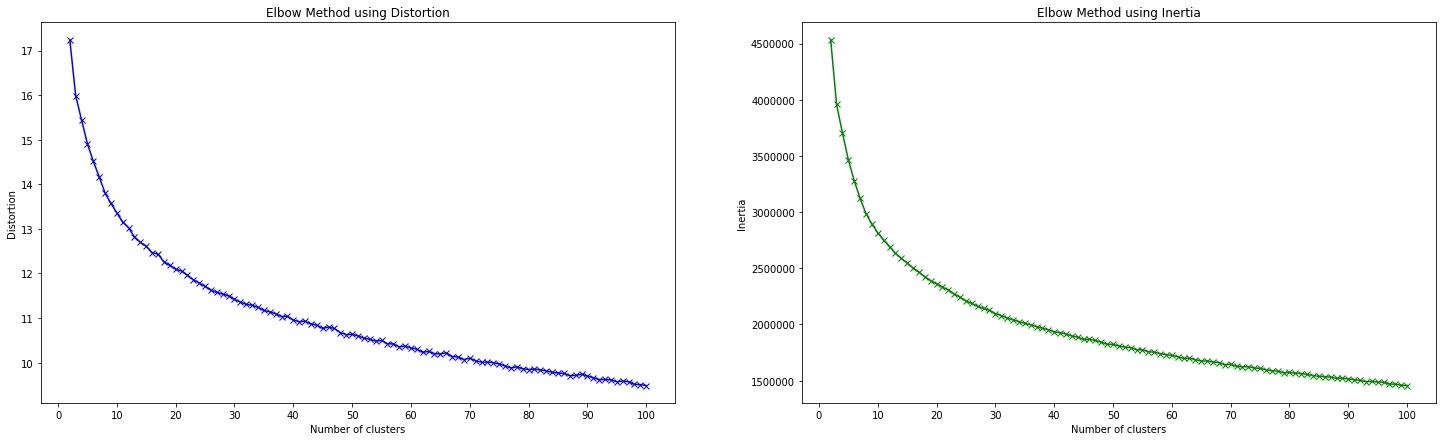

In [0]:
fig = plt.figure(figsize=(25, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(range(2, 101), distortions, 'bx-') 
ax1.set_xticks(range(0, 101, 10))
ax1.set_xlabel('Number of clusters') 
ax1.set_ylabel('Distortion') 
ax1.set_title('Elbow Method using Distortion') 

ax2.plot(range(2, 101), inertias, 'gx-') 
ax2.set_xticks(range(0, 101, 10))
ax2.set_xlabel('Number of clusters') 
ax2.set_ylabel('Inertia') 
ax2.set_title('Elbow Method using Inertia') 

fig.show()

In [0]:
kmeans = KMeans(init = 'k-means++', 
                  n_clusters = 25, 
                  n_init = 10)

kmeans.fit(PCA_components)

print('Silhouette: {}'.format(silhouette_score(PCA_components, 
                                               kmeans.labels_,
                                               metric = 'euclidean', 
                                               sample_size = 1000)))

Silhouette: 0.12396712521164671


In [0]:
print("Intercluster distance: {}".format(calculate_bc(PCA_components.to_numpy(), 
                                                   kmeans.labels_, 
                                                   kmeans.n_clusters)))
print("Intracluster distance: {}".format(calculate_wc(PCA_components.to_numpy(), 
                                                      kmeans.labels_, 
                                                      kmeans.n_clusters)))

Intercluster distance: 2653262374.296015
Intracluster distance: 84178022.83436516


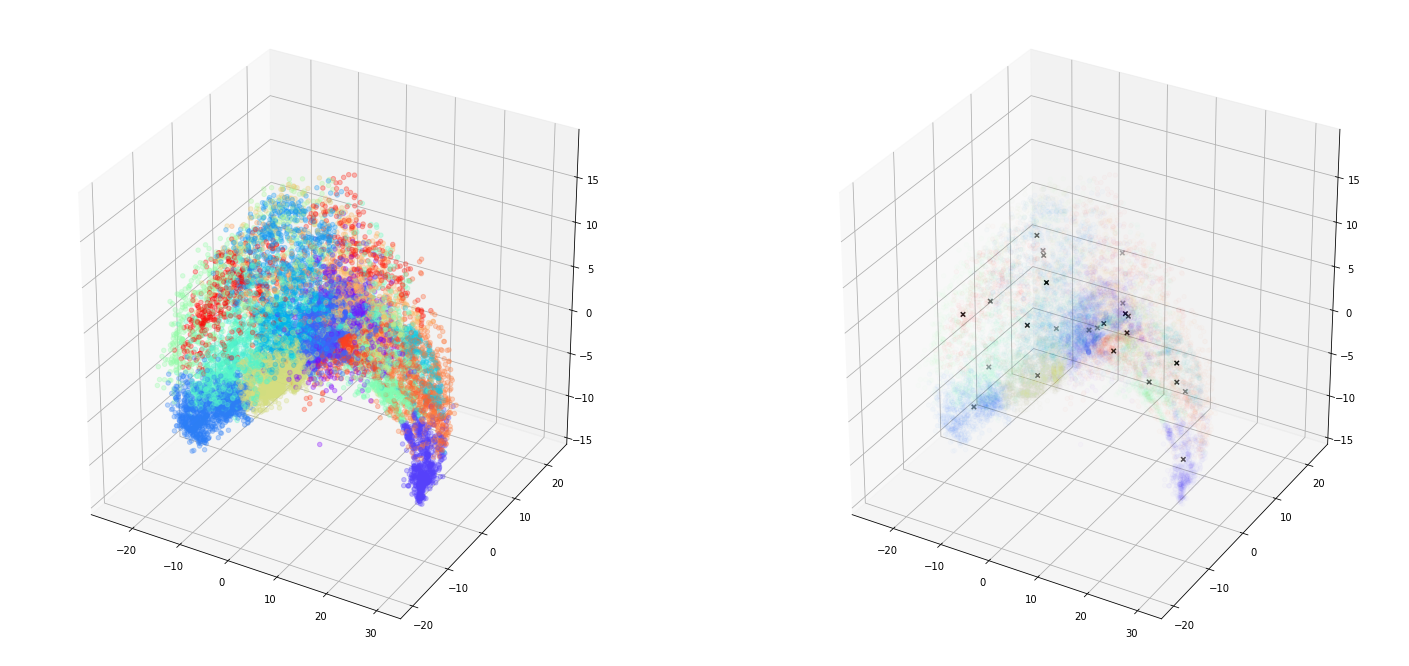

In [0]:
fig = plt.figure(num = None, figsize=(25, 12))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.scatter(PCA_components[0], 
           PCA_components[1], 
           PCA_components[2],
           c = kmeans.labels_, 
           cmap = 'rainbow',
           alpha = 0.3)
ax2.scatter(PCA_components[0], 
            PCA_components[1], 
            PCA_components[2],
            c = kmeans.labels_, 
            cmap = 'rainbow',
            alpha = 0.015)
ax2.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:, 1], 
            kmeans.cluster_centers_[:, 2],
            color = 'k', 
            marker = 'x')
# ax1.view_init(30, 120)
# ax2.view_init(30, 120)

### Intercluster-Intercluster distances method

In [104]:
kmeans_ii = KMeans(init = 'k-means++', 
                   n_clusters = ii_k, 
                   n_init = 10)

kmeans_ii.fit(PCA_components)

print('Silhouette: {}'.format(silhouette_score(PCA_components, 
                                               kmeans_ii.labels_,
                                               metric = 'euclidean', 
                                               sample_size = 1000)))

Silhouette: 0.1164869467002419


In [105]:
print("Intercluster distance: {}".format(calculate_bc(PCA_components.to_numpy(), 
                                                   kmeans_ii.labels_, 
                                                   kmeans_ii.n_clusters)))
print("Intracluster distance: {}".format(calculate_wc(PCA_components.to_numpy(), 
                                                      kmeans_ii.labels_, 
                                                      kmeans_ii.n_clusters)))

Intercluster distance: 2718419162.859649
Intracluster distance: 19034206.50818126


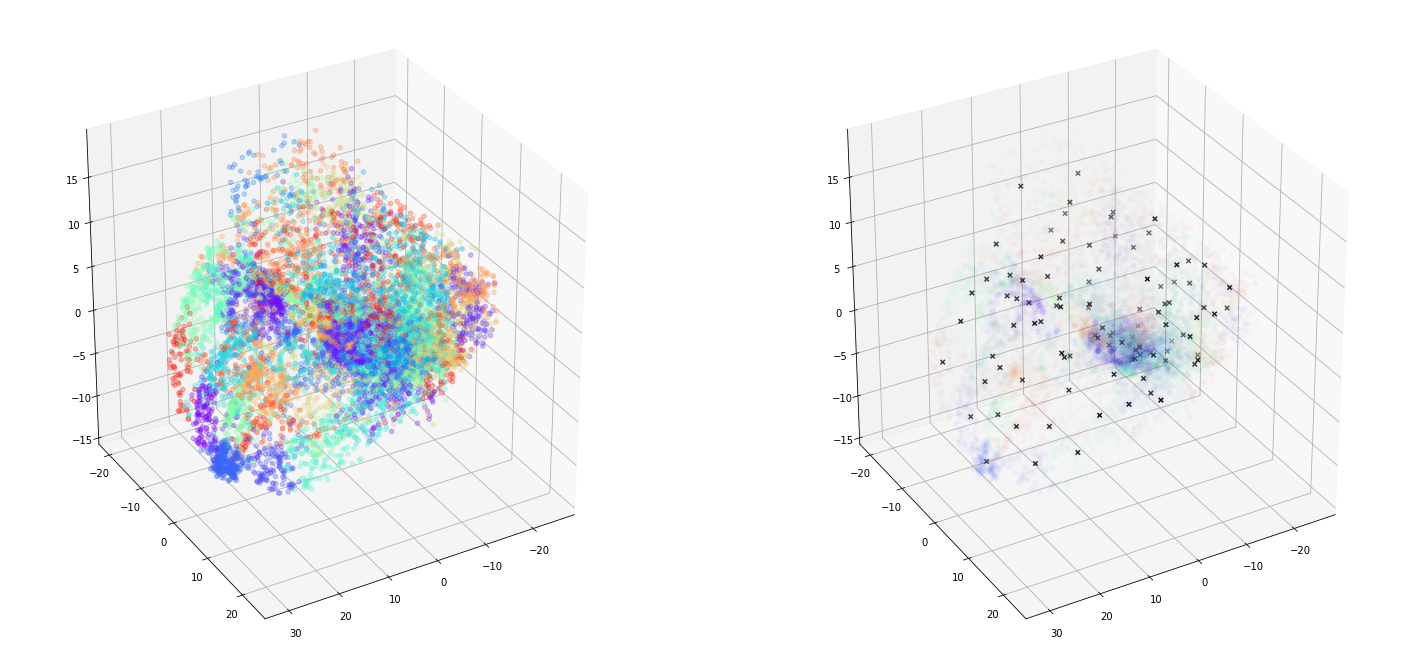

In [103]:
fig = plt.figure(num = None, figsize=(25, 12))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.scatter(PCA_components[0], 
           PCA_components[1], 
           PCA_components[2],
           c = kmeans_ii.labels_, 
           cmap = 'rainbow',
           alpha = 0.3)
ax2.scatter(PCA_components[0], 
            PCA_components[1], 
            PCA_components[2],
            c = kmeans_ii.labels_, 
            cmap = 'rainbow',
            alpha = 0.015)
ax2.scatter(kmeans_ii.cluster_centers_[:, 0], 
            kmeans_ii.cluster_centers_[:, 1], 
            kmeans_ii.cluster_centers_[:, 2],
            color = 'k', 
            marker = 'x')
ax1.view_init(30, 60)
ax2.view_init(30, 60)

### Silhouette method

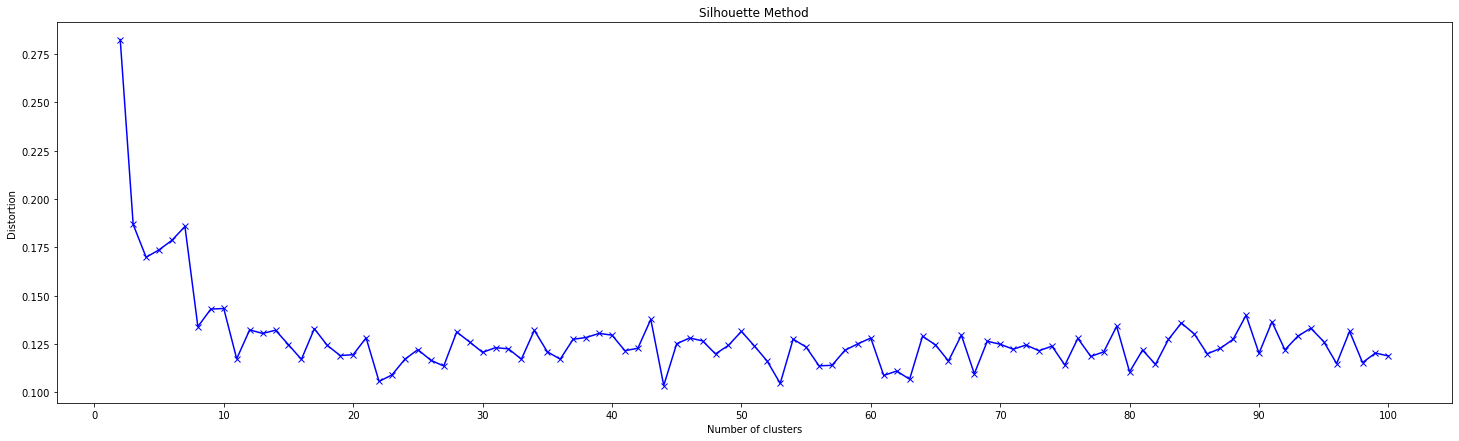

In [0]:
fig2 = plt.figure(figsize=(25, 7))
plt.plot(range(2, 101), silhouettes, 'bx-') 
plt.xticks(range(0, 101, 10))
plt.xlabel('Number of clusters') 
plt.ylabel('Distortion') 
plt.title('Silhouette Method') 
fig2.show()

In [108]:
# best_s, best_k, ks = 1, 2, 2

# for s in silhouettes:
#   if best_s < s:
#     best_s, best_k = s, ks
#   ks += 1

kmeanS = KMeans(init = 'k-means++', 
                n_clusters = 2, 
                n_init = 10)

kmeanS.fit(PCA_components)

print('Silhouette: {}'.format(silhouette_score(PCA_components, 
                                               kmeanS.labels_,
                                               metric = 'euclidean', 
                                               sample_size = 1000)))

Silhouette: 0.27215402846032716


In [109]:
print("Intercluster distance: {}".format(calculate_bc(PCA_components.to_numpy(), 
                                                   kmeanS.labels_, 
                                                   kmeanS.n_clusters)))
print("Intracluster distance: {}".format(calculate_wc(PCA_components.to_numpy(), 
                                                      kmeanS.labels_, 
                                                      kmeanS.n_clusters)))

Intercluster distance: 1418772371.597972
Intracluster distance: 1318680997.7698603


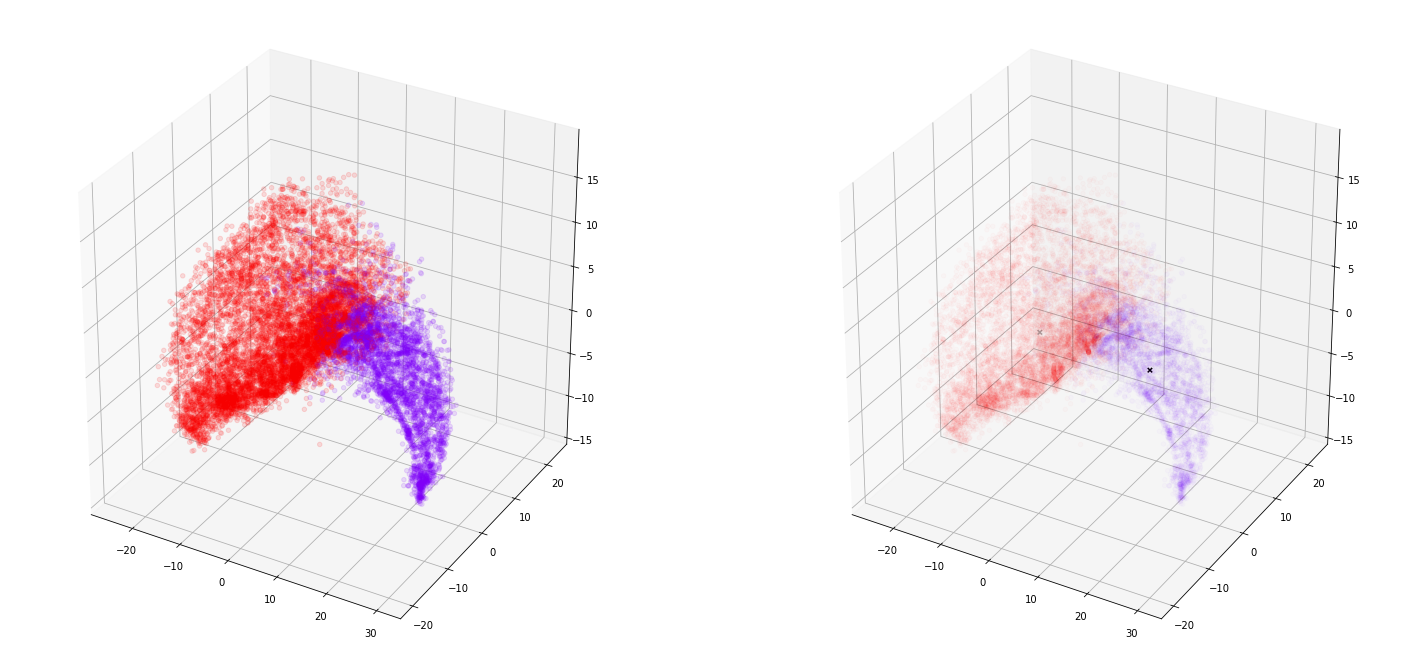

In [0]:
fig = plt.figure(num = None, figsize=(25, 12))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.scatter(PCA_components[0], 
           PCA_components[1], 
           PCA_components[2], 
           c = kmeanS.labels_, 
           cmap = 'rainbow',
           alpha = 0.12)
ax2.scatter(PCA_components[0], 
            PCA_components[1], 
            PCA_components[2],
            c = kmeanS.labels_, 
            cmap = 'rainbow',
            alpha = 0.015)
ax2.scatter(kmeanS.cluster_centers_[:, 0], 
            kmeanS.cluster_centers_[:, 1], 
            kmeanS.cluster_centers_[:, 2],
            color = 'k', 
            marker = 'x')
# ax.view_init(1, 110)

## DBSCAN

In [0]:
distances_db = []
ii_max, ii_eps = 1000000, -1

for eps in range(10, 101, 10):
  dbscan = DBSCAN(eps = eps, 
                  min_samples = 4)

  dbscan.fit(PCA_components)

  n_clusters = pd.Series(dbscan.labels_).unique().shape[0]

  ii = maximize(PCA_components.to_numpy(), dbscan.labels_, n_clusters)
  if ii > ii_max:
    ii_max = ii
    ii_eps = eps

In [112]:
dbscan = DBSCAN(eps = ii_eps, 
                min_samples = 4)

dbscan.fit(PCA_components)

DBSCAN(algorithm='auto', eps=10, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=4, n_jobs=None, p=None)

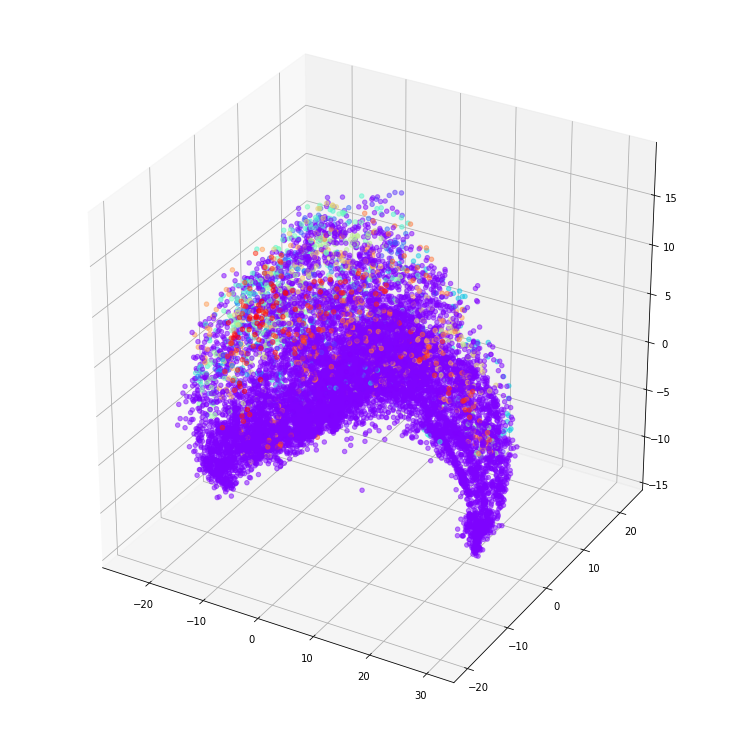

In [113]:
fig = plt.figure(num = None, figsize=(10, 10))
ax = Axes3D(fig)
ax.scatter(PCA_components[0], 
           PCA_components[1], 
           PCA_components[2],
           c = dbscan.labels_, 
           cmap = 'rainbow',
           alpha = 0.5)
# ax.view_init(30, 360)

In [115]:
n_clusters = pd.Series(dbscan.labels_).unique().shape[0]

print("Intercluster distance: {}".format(calculate_bc(PCA_components.to_numpy(), 
                                                   dbscan.labels_, 
                                                   n_clusters)))
print("Intracluster distance: {}".format(calculate_wc(PCA_components.to_numpy(), 
                                                      dbscan.labels_, 
                                                      n_clusters)))

Intercluster distance: 770415164.1513163
Intracluster distance: 1851433050.8059065


## Mean Shift

In [0]:
best_silhouette, optimal_quantile = 0, 0.5
distortions = []
mapping1 = {}
ii_max_ms, ii_quant = -10000, 0

for quantile in [x / 100 for x in range(10, 101, 5)]:
  bandwidth = estimate_bandwidth(PCA_components, 
                                 quantile = quantile, 
                                 n_samples = 100)
  
  ms = MeanShift(bandwidth = bandwidth, 
                bin_seeding = True)
  
  ms.fit(PCA_components)
  
  distortions.append(sum(np.min(cdist(PCA_components, 
                                      ms.cluster_centers_, 
                                      'euclidean'), axis = 1)) / \
                     PCA_components.shape[0]) 
  
  n_clusters = pd.Series(ms.labels_).unique().shape[0]
  ii = maximize(PCA_components.to_numpy(), ms.labels_, n_clusters)
  if ii > ii_max_ms:
    ii_max_ms = ii
    ii_quant = quantile

In [21]:
print('Best quantile to maximize our summed metric {}:'.format(ii_quant))

Best quantile to maximize our summed metric 0.1:


### Elbow Method

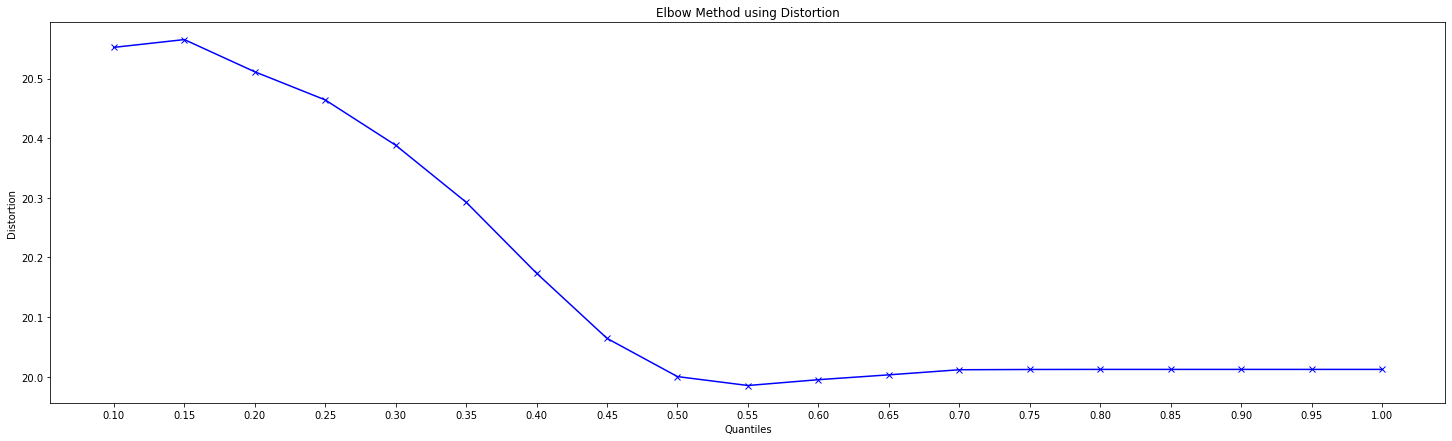

In [0]:
fig = plt.figure(figsize=(25, 7))
plt.plot([x / 100 for x in range(10, 101, 5)], distortions, 'bx-') 
plt.xticks([x / 100 for x in range(10, 101, 5)])
plt.xlabel('Quantiles') 
plt.ylabel('Distortion') 
plt.title('Elbow Method using Distortion') 
fig.show()

In [116]:
bandwidth = estimate_bandwidth(PCA_components, 
                               quantile = 0.6, 
                               n_samples = 100)

ms = MeanShift(bandwidth = bandwidth, 
               bin_seeding = True)

ms.fit(PCA_components)

MeanShift(bandwidth=31.482167828597323, bin_seeding=True, cluster_all=True,
          max_iter=300, min_bin_freq=1, n_jobs=None, seeds=None)

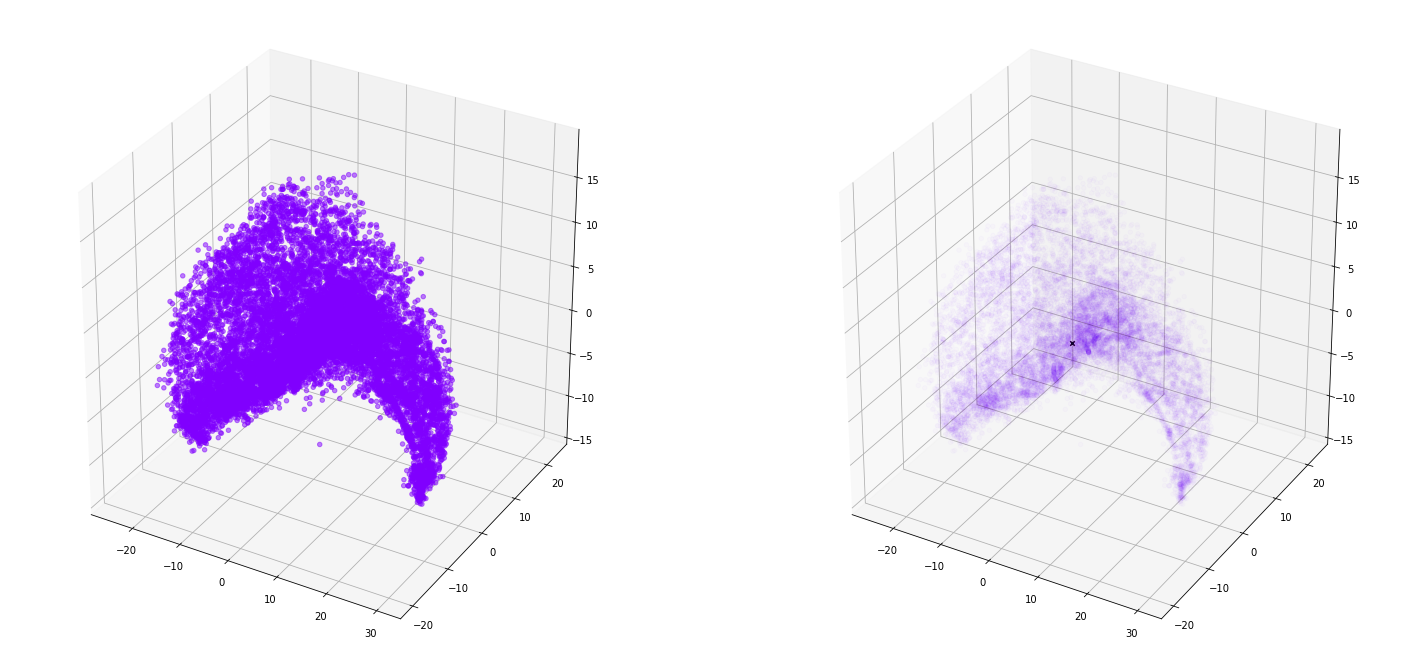

In [0]:
fig = plt.figure(num = None, figsize=(25, 12))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.scatter(PCA_components[0], 
            PCA_components[1], 
            PCA_components[2],
            c = ms.labels_, 
            cmap = 'rainbow',
            alpha = 0.5)
ax2.scatter(PCA_components[0], 
            PCA_components[1], 
            PCA_components[2],
            c = ms.labels_, 
            cmap = 'rainbow',
            alpha = 0.015)
ax2.scatter(ms.cluster_centers_[:, 0], 
            ms.cluster_centers_[:, 1], 
            ms.cluster_centers_[:, 2],
            color = 'k', 
            marker = 'x')

### Intracluster-intercluster optimum quantile


In [61]:
bandwidth = estimate_bandwidth(PCA_components, 
                               quantile = ii_quant, 
                               n_samples = 100)

ms = MeanShift(bandwidth = bandwidth, 
               bin_seeding = True)

ms.fit(PCA_components)

MeanShift(bandwidth=19.911005918140564, bin_seeding=True, cluster_all=True,
          max_iter=300, min_bin_freq=1, n_jobs=None, seeds=None)

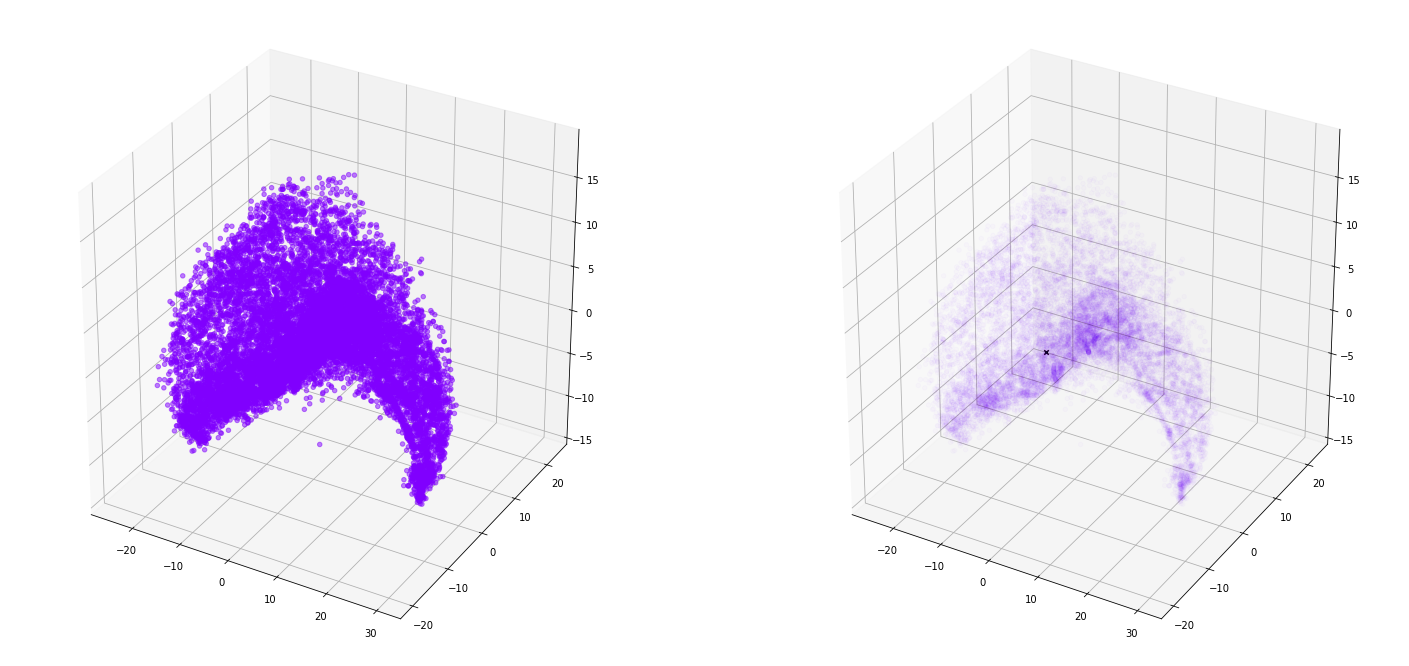

In [63]:
fig = plt.figure(num = None, figsize=(25, 12))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.scatter(PCA_components[0], 
           PCA_components[1], 
           PCA_components[2],
           c = ms.labels_, 
           cmap = 'rainbow',
           alpha = 0.5)
ax2.scatter(PCA_components[0], 
            PCA_components[1], 
            PCA_components[2],
            c = ms.labels_, 
            cmap = 'rainbow',
            alpha = 0.015)
ax2.scatter(ms.cluster_centers_[:, 0], 
            ms.cluster_centers_[:, 1], 
            ms.cluster_centers_[:, 2],
            color = 'k', 
            marker = 'x')
# ax.view_init(30, 30)

## Hierarchical Clustering

In [0]:
best_silhouette, optimal_no_clusters = -100, 0
ii_max_agg, ii_k_agg = -10000, 0

for no_of_clusters in range(2, 100):
  agg = AgglomerativeClustering(n_clusters = no_of_clusters)
  agg.fit(PCA_components)
  silhouette = silhouette_score(PCA_components, 
                                agg.labels_,
                                metric = 'euclidean', 
                                sample_size = 1000)
  
  if silhouette > best_silhouette:
    best_silhouette = silhouette
    optimal_no_clusters = no_of_clusters

  ii = maximize(PCA_components.to_numpy(), agg.labels_, agg.n_clusters)
  if ii > ii_max_agg:
    ii_max_agg = ii
    ii_k_agg = no_of_clusters

### Best intracluster-intercluster k

In [27]:
print('Best number of clusters to maximize our summed metric: {}'.format(ii_k_agg))

Best number of clusters to maximize our summed metric 99:


In [122]:
agg_ii = AgglomerativeClustering(n_clusters = ii_k_agg)

agg_ii.fit(PCA_components)

print('Silhouette: {}'.format(silhouette_score(PCA_components, 
                                               agg_ii.labels_,
                                               metric = 'euclidean', 
                                               sample_size = 1000)))
print("Intercluster distance: {}".format(calculate_bc(PCA_components.to_numpy(), 
                                                   agg_ii.labels_, 
                                                   agg_ii.n_clusters)))
print("Intracluster distance: {}".format(calculate_wc(PCA_components.to_numpy(), 
                                                      agg_ii.labels_, 
                                                      agg_ii.n_clusters)))

Silhouette: 0.12003002125931372
Intercluster distance: 2716626927.5763545
Intracluster distance: 20826441.791468382


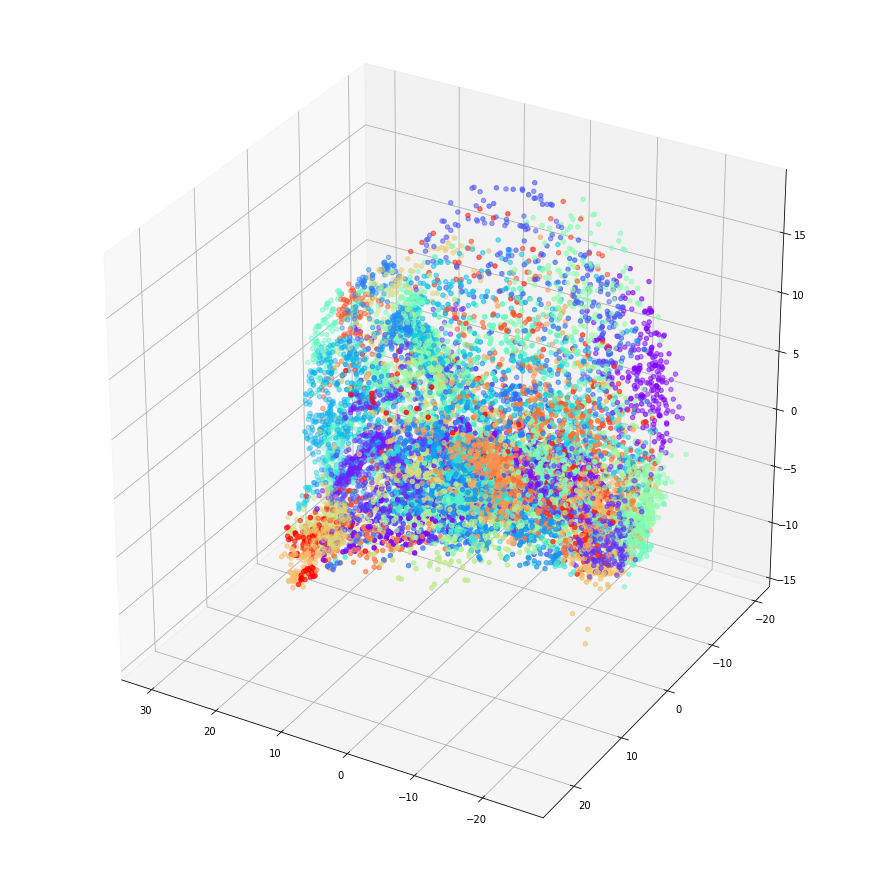

In [82]:
fig = plt.figure(num = None, figsize=(12, 12))
ax = Axes3D(fig)
ax.scatter(PCA_components[0], 
           PCA_components[1], 
           PCA_components[2],
           c = agg_ii.labels_,
           cmap = 'rainbow')
# ax.view_init(30, 120)

### K-Means Elbow Best k



In [121]:
agg = AgglomerativeClustering(n_clusters = 25)

agg.fit(PCA_components)

print('Silhouette: {}'.format(silhouette_score(PCA_components, 
                                               agg.labels_,
                                               metric = 'euclidean', 
                                               sample_size = 1000)))
print("Intercluster distance: {}".format(calculate_bc(PCA_components.to_numpy(), 
                                                   agg.labels_, 
                                                   agg.n_clusters)))
print("Intracluster distance: {}".format(calculate_wc(PCA_components.to_numpy(), 
                                                      agg.labels_, 
                                                      agg.n_clusters)))

Silhouette: 0.09696238365307305
Intercluster distance: 2647809555.3413167
Intracluster distance: 89643814.02650206


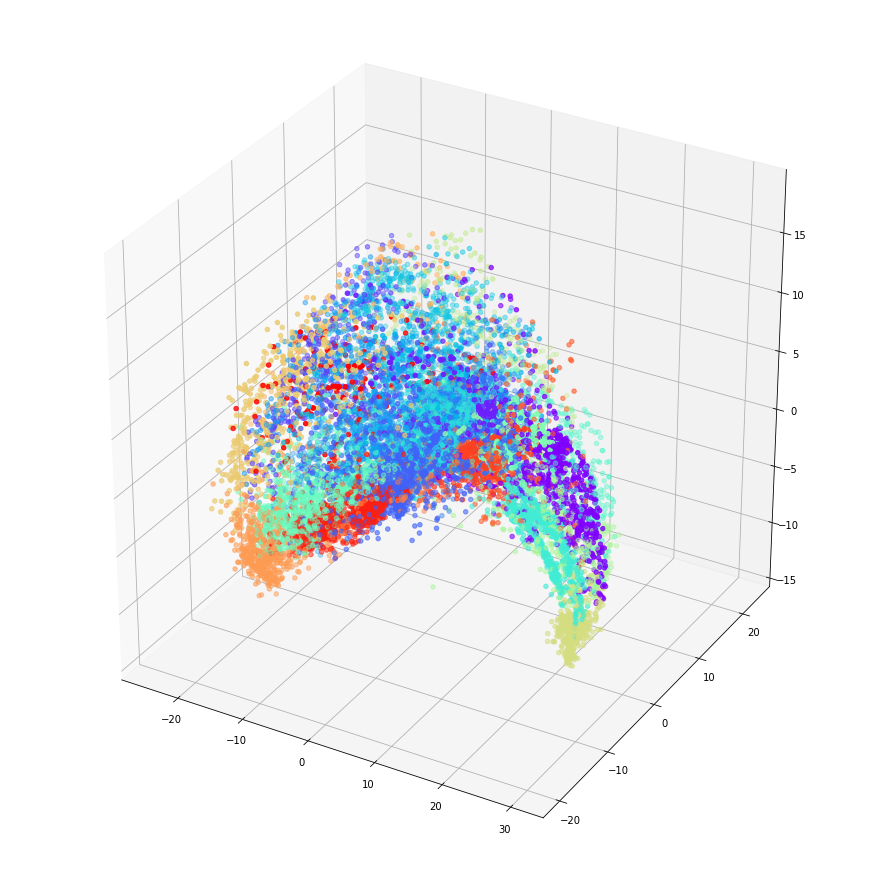

In [0]:
fig = plt.figure(num = None, figsize=(12, 12))
ax = Axes3D(fig)
ax.scatter(PCA_components[0], 
           PCA_components[1], 
           PCA_components[2],
           c = agg.labels_,
           cmap = 'rainbow')
# ax.view_init(30, 120)

## Birch

In [0]:
best_silhouette, optimal_no_clusters, optimal_threshold = -100, 0, 0
ii_max_brc, ii_thresh, ii_k_brc = -1000, 0, 0

for no_of_clusters in range(2, 16):
  for thresh in [x / 100 for x in range(10, 51, 5)]:
    brc = Birch(threshold = thresh, 
                n_clusters = no_of_clusters)

    brc.fit(PCA_components)

    silhouette = silhouette_score(PCA_components, 
                                  brc.labels_,
                                  metric = 'euclidean', 
                                  sample_size = 100)
    
    if silhouette > best_silhouette:
      best_silhouette = silhouette
      optimal_no_clusters = no_of_clusters
      optimal_threshold = thresh

    ii = maximize(PCA_components.to_numpy(), brc.labels_, brc.n_clusters)
    if ii > ii_max_brc:
      ii_max_brc = ii
      ii_thresh = thresh
      ii_k_brc = no_of_clusters

In [84]:
print('Best number of clusters and threshold to maximize our intracluster-intercluster metric: {}, {}'.format(ii_k_brc, ii_thresh))

Best number of clusters and threshold to maximize our intracluster-intercluster metric: 15, 0.1


In [85]:
print('Best number of clusters and threshold to maximize Silhouette: {}, {}'.format(optimal_no_clusters, optimal_threshold))

Best number of clusters and threshold to maximize Silhouette: 2, 0.15


In [125]:
brc = Birch(threshold = optimal_threshold, 
            branching_factor = 100, 
            n_clusters = 25)

brc.fit(PCA_components)

print('Silhouette: {}'.format(silhouette_score(PCA_components, 
                                               brc.labels_, 
                                               metric = 'euclidean', 
                                               sample_size = 1000)))
print("Intercluster distance: {}".format(calculate_bc(PCA_components.to_numpy(), 
                                                   brc.labels_, 
                                                   brc.n_clusters)))
print("Intracluster distance: {}".format(calculate_wc(PCA_components.to_numpy(), 
                                                      brc.labels_, 
                                                      brc.n_clusters)))

Silhouette: 0.09472825960721697
Intercluster distance: 2634713554.5883026
Intracluster distance: 102739814.77952224


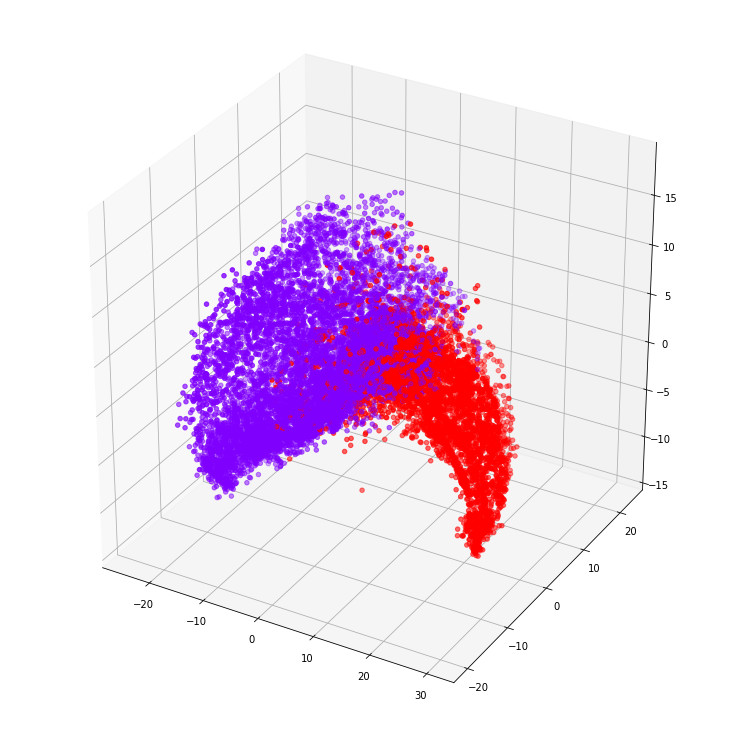

In [87]:
fig = plt.figure(num = None, figsize=(10, 10))
ax = Axes3D(fig)
ax.scatter(PCA_components[0], 
           PCA_components[1], 
           PCA_components[2],
           c = brc.labels_, 
           cmap = 'rainbow')
# ax.view_init(30, 120)

### Best intracluster-intercluster k

In [128]:
brc = Birch(threshold = ii_thresh, 
            branching_factor = 100, 
            n_clusters = ii_k_brc)

brc.fit(PCA_components)

print('Silhouette: {}'.format(silhouette_score(PCA_components, 
                                               brc.labels_, 
                                               metric = 'euclidean', 
                                               sample_size = 1000)))
print("Intercluster distance: {}".format(calculate_bc(PCA_components.to_numpy(), 
                                                   brc.labels_, 
                                                   brc.n_clusters)))
print("Intracluster distance: {}".format(calculate_wc(PCA_components.to_numpy(), 
                                                      brc.labels_, 
                                                      brc.n_clusters)))

Silhouette: 0.10225087785037541
Intercluster distance: 2586900961.446753
Intracluster distance: 150552407.92106754


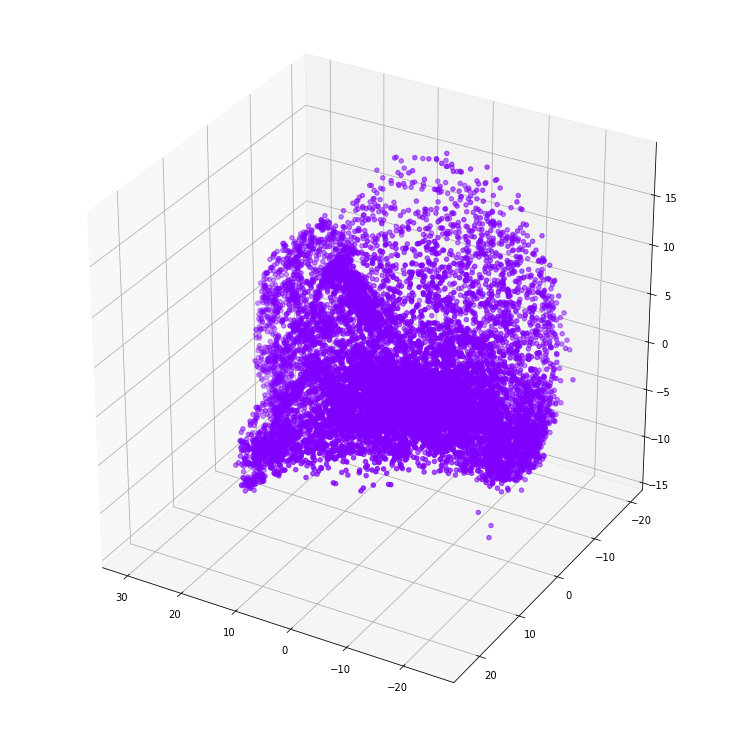

In [94]:
fig = plt.figure(num = None, figsize=(10, 10))
ax = Axes3D(fig)
ax.scatter(PCA_components[0], 
           PCA_components[1], 
           PCA_components[2],
           c = brc.labels_, 
           cmap = 'rainbow')
ax.view_init(30, 120)

### Silhouette

In [130]:
brc = Birch(threshold = optimal_threshold, 
            branching_factor = 100, 
            n_clusters = optimal_no_clusters)

brc.fit(PCA_components)

print('Silhouette: {}'.format(silhouette_score(PCA_components, 
                                               brc.labels_, 
                                               metric = 'euclidean', 
                                               sample_size = 1000)))
print("Intercluster distance: {}".format(calculate_bc(PCA_components.to_numpy(), 
                                                   brc.labels_, 
                                                   brc.n_clusters)))
print("Intracluster distance: {}".format(calculate_wc(PCA_components.to_numpy(), 
                                                      brc.labels_, 
                                                      brc.n_clusters)))

Silhouette: 0.27758729449712133
Intercluster distance: 1412347829.2406697
Intracluster distance: 1325105540.1271546


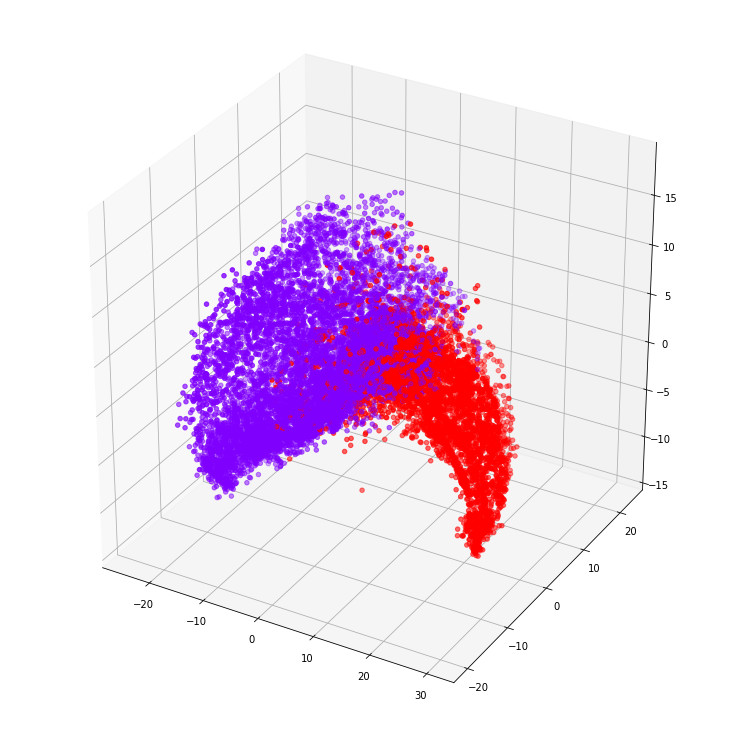

In [100]:
fig = plt.figure(num = None, figsize=(10, 10))
ax = Axes3D(fig)
ax.scatter(PCA_components[0], 
           PCA_components[1], 
           PCA_components[2],
           c = brc.labels_, 
           cmap = 'rainbow')
ax.view_init(30, 300)